In [1]:
import os
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import functional as F

import random

from tqdm import tqdm

In [2]:
SEED = 1834579290

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
class Conf:
    max_power_db = -5
    min_power_db = -28

    train_dir = '/kaggle/input/berkeley-segmentation-dataset-500-bsds500/images/train'
    val_dir = '/kaggle/input/berkeley-segmentation-dataset-500-bsds500/images/val'
    test_dir = '/kaggle/input/berkeley-segmentation-dataset-500-bsds500/images/test'

    batch_size = 8

    d = 21
    receptive_field = 2 * d + 1
    image_hw = 10 * receptive_field
    dimensions = (image_hw, image_hw, 3)

    patch_size = receptive_field
    stride = 3 * receptive_field // 4

In [4]:
def gaussian_noise(power_db, dim):
    power_linear = 10 ** (power_db / 10)
    std_dev = np.sqrt(power_linear)
    noise_image = np.random.normal(loc=0, scale=std_dev, size=dim)

    clamped_noise = np.clip(noise_image, 0, 1)
    
    return clamped_noise

In [5]:
class NoisyImageDataset(Dataset):
    def __init__(self, image_dir, min_power_db, max_power_db, patch_size, stride, transform=None):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.lower().endswith(('png', 'jpg', 'jpeg'))]
        self.min_power_db = min_power_db
        self.max_power_db = max_power_db
        self.patch_size = patch_size
        self.stride = stride
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def extract_patches(self, image):
        patches = []
        _, h, w = image.shape
        for i in range(0, h - self.patch_size + 1, self.stride):
            for j in range(0, w - self.patch_size + 1, self.stride):
                patch = image[:, i:i + self.patch_size, j:j + self.patch_size]
                patches.append(patch)
        return patches

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        patches = self.extract_patches(image)

        noisy_patches = []
        # noise_patches = []
        noise_power = random.uniform(self.min_power_db, self.max_power_db)
        for patch in patches:
            noise = torch.Tensor(gaussian_noise(noise_power, patch.shape)).float()
            noisy_patch = patch + noise
            noisy_patch = torch.clamp(noisy_patch, 0, 1).float()
            noisy_patches.append(noisy_patch)
            # noise_patches.append(noise)

        return torch.stack(noisy_patches), torch.stack(patches)

In [6]:
transform = transforms.Compose([
    transforms.Resize((Conf.image_hw, Conf.image_hw)),
    transforms.ToTensor()
])

train_dataset = NoisyImageDataset(Conf.train_dir, Conf.min_power_db, Conf.max_power_db, Conf.patch_size, Conf.stride, transform=transform)
val_dataset = NoisyImageDataset(Conf.val_dir, Conf.min_power_db, Conf.max_power_db, Conf.patch_size, Conf.stride, transform=transform)
test_dataset = NoisyImageDataset(Conf.val_dir, Conf.min_power_db, Conf.max_power_db, Conf.patch_size, Conf.stride, transform=transform)

def flatten_loader(dataset, batch_size, shuffle):
    all_noisy_patches = []
    all_noise_patches = []
    for noisy_patches, noise_patches in dataset:
        all_noisy_patches.extend(noisy_patches)
        all_noise_patches.extend(noise_patches)
    dataset = list(zip(all_noisy_patches, all_noise_patches))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = flatten_loader(train_dataset, Conf.batch_size, True)
val_loader = flatten_loader(val_dataset, Conf.batch_size, True)
test_loader = flatten_loader(test_dataset, Conf.batch_size, False)

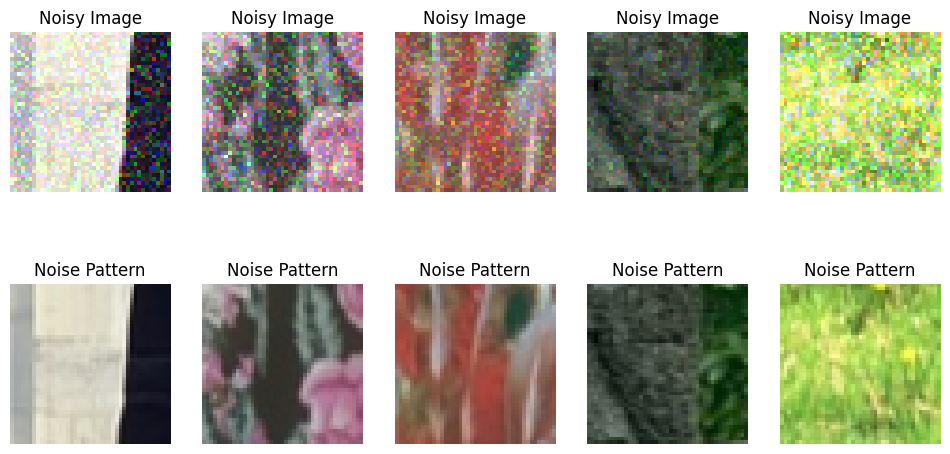

In [7]:
def display_samples(loader, num_samples=5):
    samples_displayed = 0
    plt.figure(figsize=(12, 6))
    for noisy_images, noises in loader:
        for i in range(noisy_images.size(0)):
            if samples_displayed >= num_samples:
                plt.show()
                return
            
            plt.subplot(2, num_samples, samples_displayed + 1)
            plt.imshow(noisy_images[i].permute(1, 2, 0).numpy())
            plt.title("Noisy Image")
            plt.axis('off')

            plt.subplot(2, num_samples, samples_displayed + 1 + num_samples)
            plt.imshow(noises[i].permute(1, 2, 0).numpy(), cmap='gray')
            plt.title("Noise Pattern")
            plt.axis('off')
            
            samples_displayed += 1

display_samples(val_loader)

In [8]:
class EarlyStopping:
    def __init__(self, tolerance=10, min_delta=0.01):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.min_loss = float('inf')
        self.counter = 0
        self.early_stop = False
        self.model_dict = None
        self.optim_dict = None
        self.epoch = -1
        
    def __call__(self, val_loss, model_dict, optim_dict, epoch):
        if (self.min_loss - val_loss) > self.min_delta:
            self.counter = 0
            self.min_loss = val_loss
            self.model_dict = model_dict
            self.optim_dict = optim_dict
            self.epoch = epoch
        else:
            self.counter += 1
            if self.counter >= self.tolerance:
                self.early_stop = True

In [9]:
class DnCNN(nn.Module):
    def __init__(self, in_channels=3, depth=17, num_filters=64):
        super(DnCNN, self).__init__()
        
        layers = []
        
        # First layer: Conv + ReLU
        layers.append(nn.Conv2d(in_channels, num_filters, kernel_size=3, padding=1, bias=False))
        layers.append(nn.ReLU(inplace=True))
        
        # Middle layers: Conv + BatchNorm + ReLU
        for _ in range(depth - 2):
            layers.append(nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(num_filters))
            layers.append(nn.ReLU(inplace=True))
        
        # Last layer: Conv (no activation or normalization)
        layers.append(nn.Conv2d(num_filters, in_channels, kernel_size=3, padding=1, bias=False))

        layers.append(nn.Sigmoid())
        
        self.dncnn = nn.Sequential(*layers)
    
    def forward(self, x):
        return x - self.dncnn(x)

Epoch 1/50: 100%|██████████| 4225/4225 [00:56<00:00, 75.26it/s]


Epoch 1/50 | Train Loss: 0.0061 | Val Loss: 0.0012


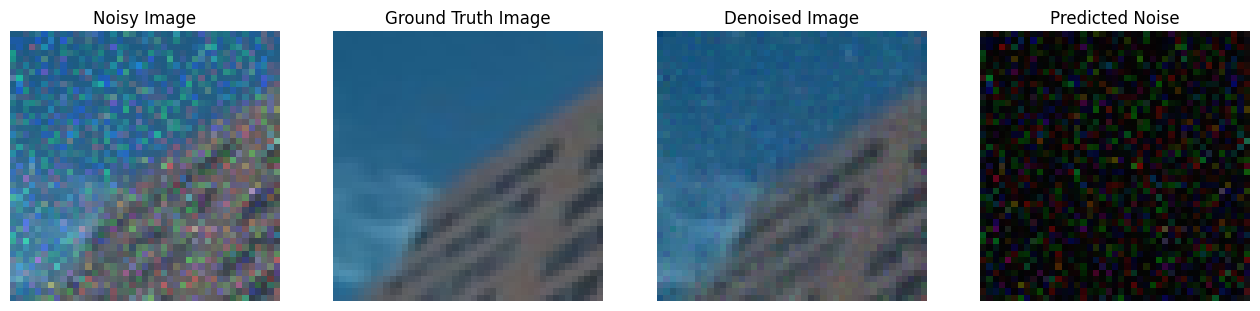

Epoch 2/50: 100%|██████████| 4225/4225 [00:55<00:00, 76.68it/s]


Epoch 2/50 | Train Loss: 0.0013 | Val Loss: 0.0011


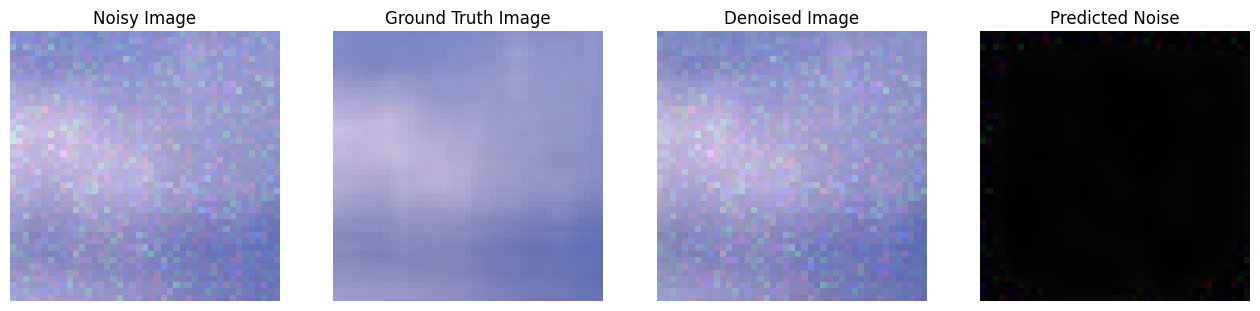

Epoch 3/50: 100%|██████████| 4225/4225 [00:55<00:00, 76.56it/s]


Epoch 3/50 | Train Loss: 0.0009 | Val Loss: 0.0010


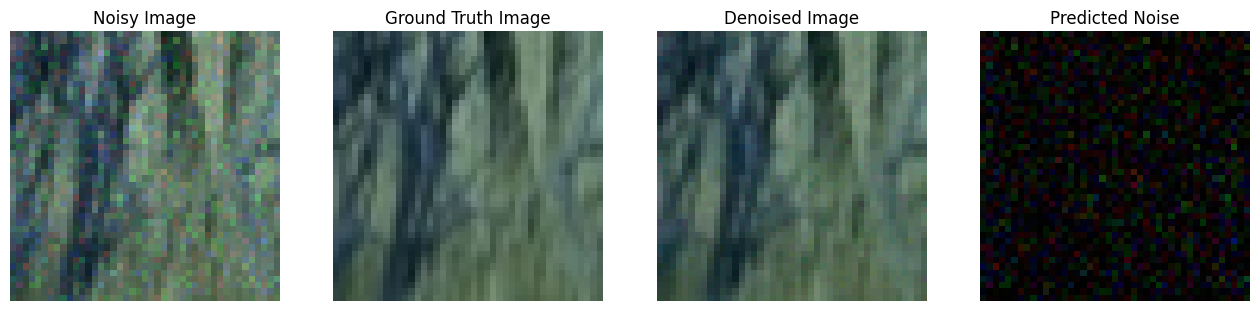

Epoch 4/50: 100%|██████████| 4225/4225 [00:55<00:00, 76.62it/s]


Epoch 4/50 | Train Loss: 0.0007 | Val Loss: 0.0006


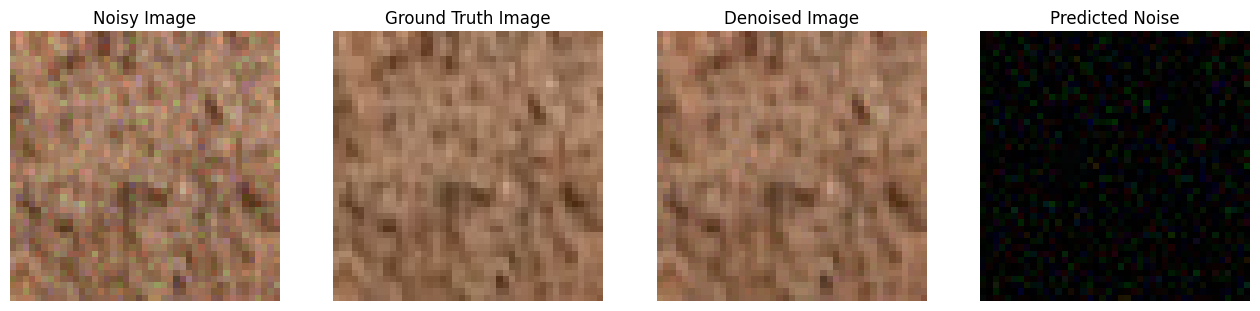

Epoch 5/50: 100%|██████████| 4225/4225 [00:55<00:00, 76.42it/s]


Epoch 5/50 | Train Loss: 0.0006 | Val Loss: 0.0006


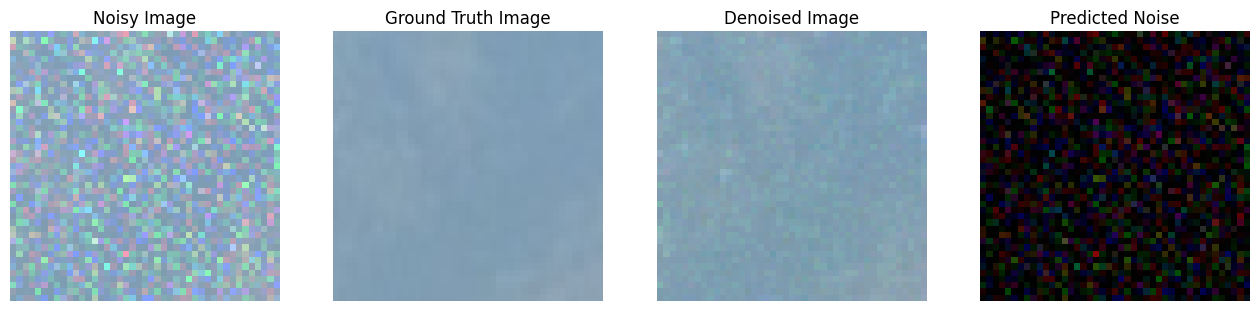

Epoch 6/50: 100%|██████████| 4225/4225 [00:55<00:00, 76.73it/s]


Epoch 6/50 | Train Loss: 0.0005 | Val Loss: 0.0003


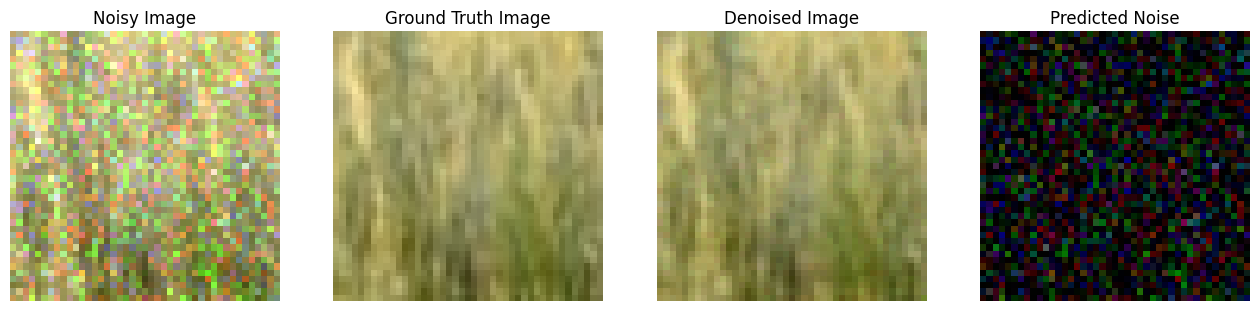

Epoch 7/50: 100%|██████████| 4225/4225 [00:55<00:00, 76.47it/s]


Epoch 7/50 | Train Loss: 0.0005 | Val Loss: 0.0004


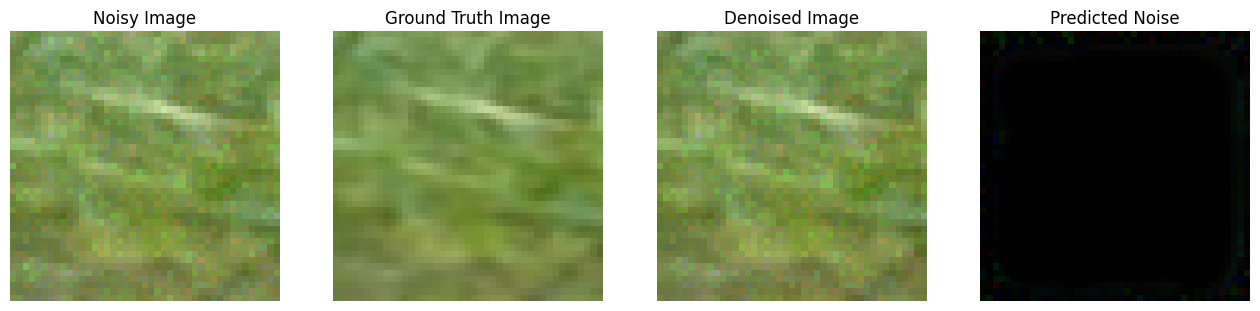

Epoch 8/50: 100%|██████████| 4225/4225 [00:54<00:00, 76.92it/s]


Epoch 8/50 | Train Loss: 0.0004 | Val Loss: 0.0003


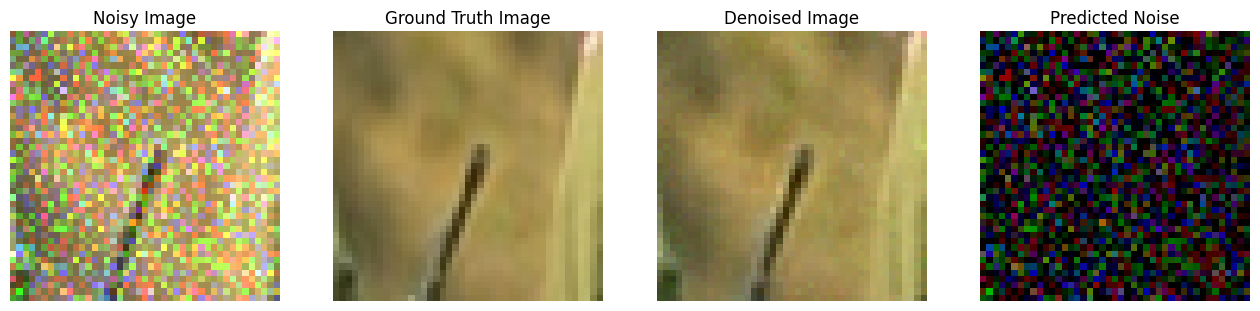

Epoch 9/50: 100%|██████████| 4225/4225 [00:54<00:00, 76.99it/s]


Epoch 9/50 | Train Loss: 0.0004 | Val Loss: 0.0004


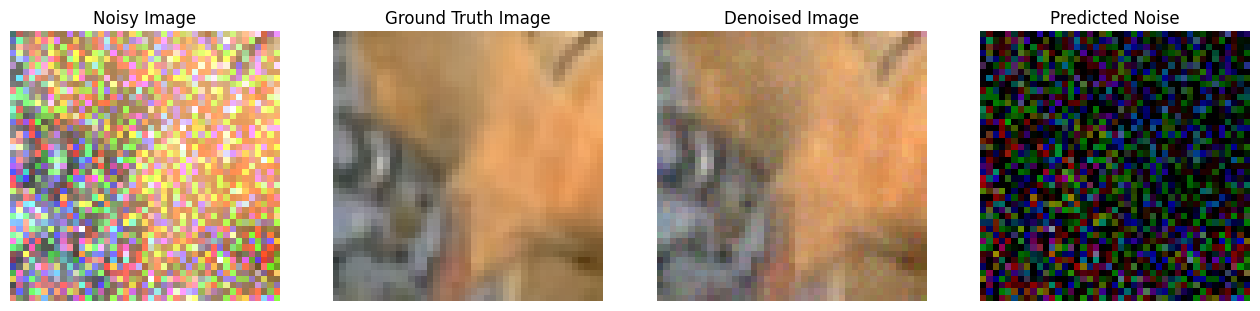

Epoch 10/50: 100%|██████████| 4225/4225 [00:54<00:00, 76.94it/s]


Epoch 10/50 | Train Loss: 0.0003 | Val Loss: 0.0003


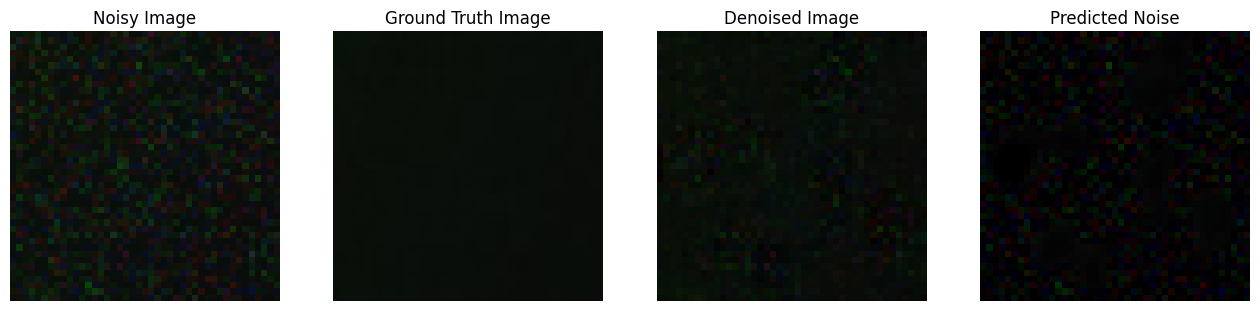

Epoch 11/50: 100%|██████████| 4225/4225 [00:54<00:00, 77.11it/s]


Epoch 11/50 | Train Loss: 0.0003 | Val Loss: 0.0003


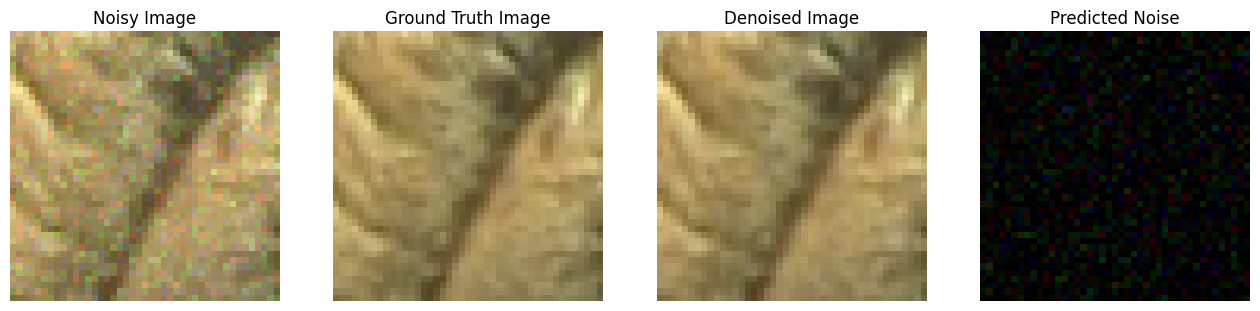

Epoch 12/50: 100%|██████████| 4225/4225 [00:54<00:00, 76.83it/s]


Epoch 12/50 | Train Loss: 0.0003 | Val Loss: 0.0003


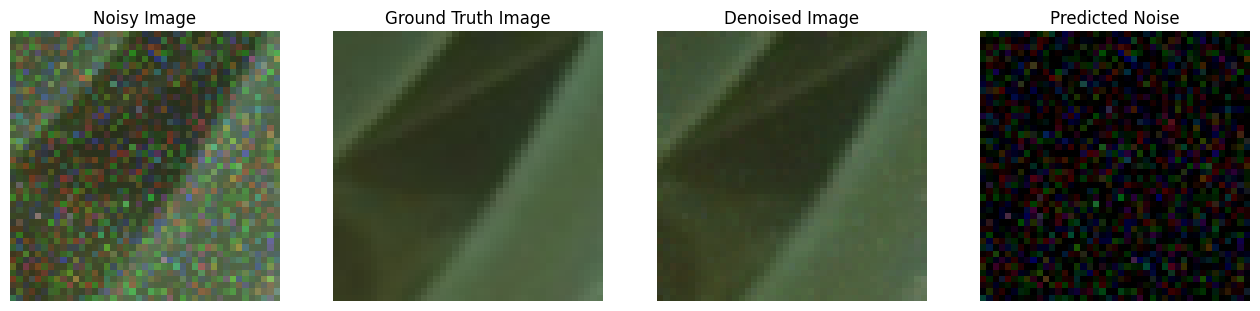

Epoch 13/50: 100%|██████████| 4225/4225 [00:55<00:00, 76.62it/s]


Epoch 13/50 | Train Loss: 0.0003 | Val Loss: 0.0004


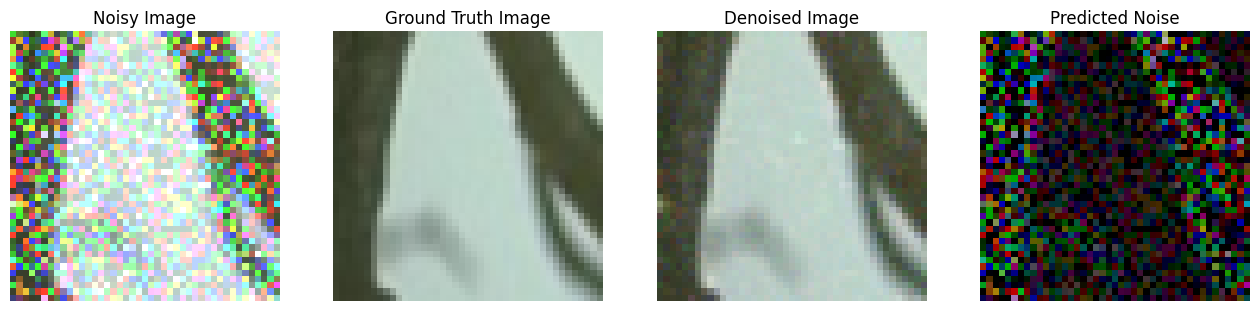

Epoch 14/50: 100%|██████████| 4225/4225 [00:55<00:00, 76.63it/s]


Epoch 14/50 | Train Loss: 0.0003 | Val Loss: 0.0003


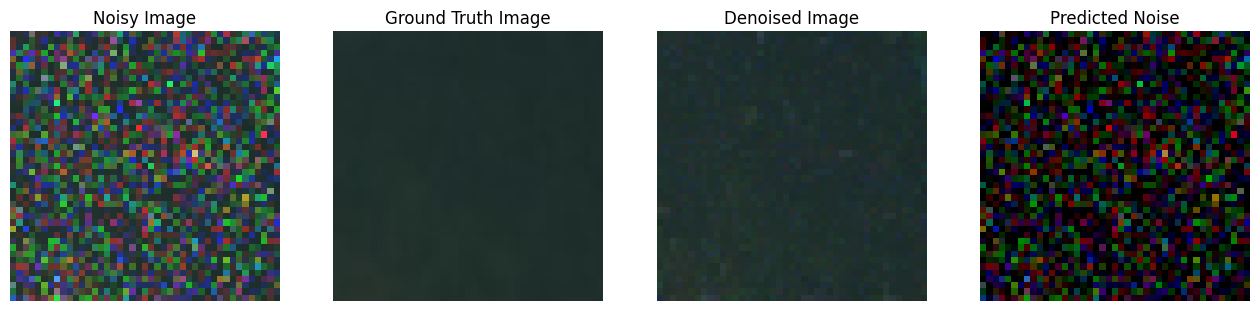

Epoch 15/50: 100%|██████████| 4225/4225 [00:54<00:00, 76.87it/s]


Epoch 15/50 | Train Loss: 0.0003 | Val Loss: 0.0003


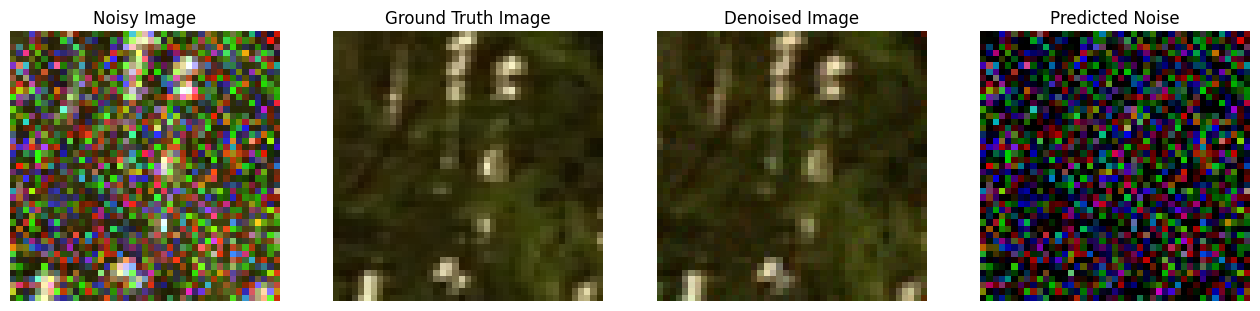

Epoch 16/50: 100%|██████████| 4225/4225 [00:54<00:00, 76.88it/s]


Epoch 16/50 | Train Loss: 0.0002 | Val Loss: 0.0002


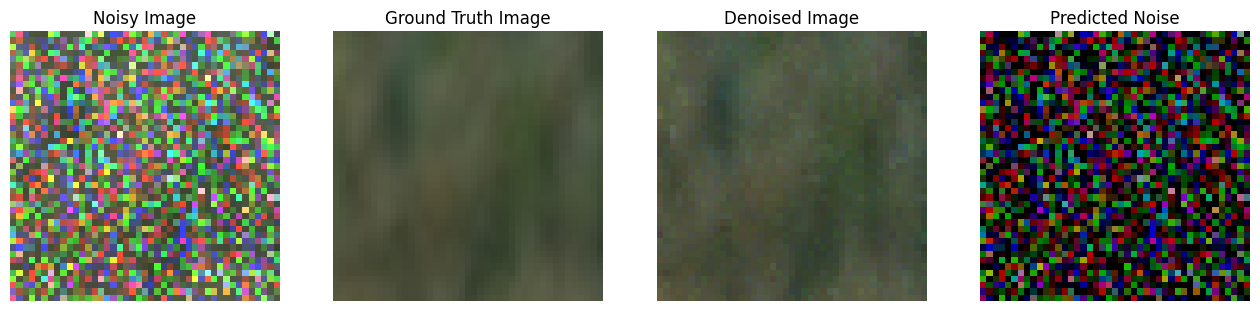

Epoch 17/50: 100%|██████████| 4225/4225 [00:55<00:00, 76.40it/s]


Epoch 17/50 | Train Loss: 0.0002 | Val Loss: 0.0003


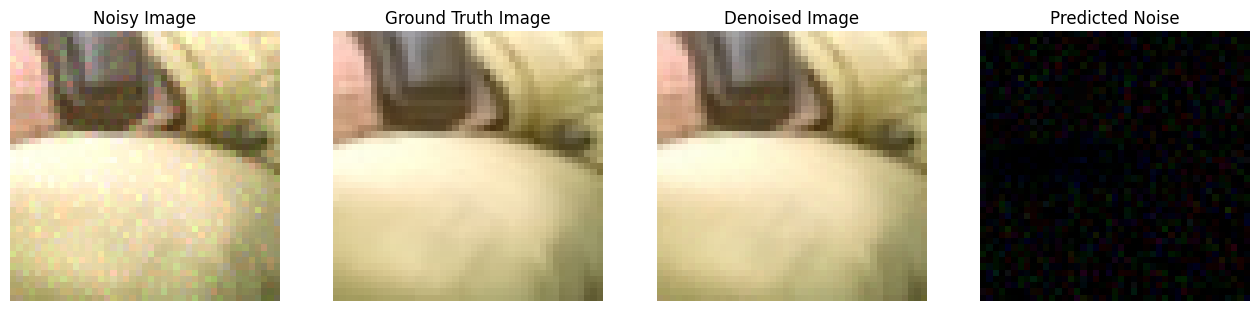

Epoch 18/50: 100%|██████████| 4225/4225 [00:55<00:00, 76.41it/s]


Epoch 18/50 | Train Loss: 0.0002 | Val Loss: 0.0003


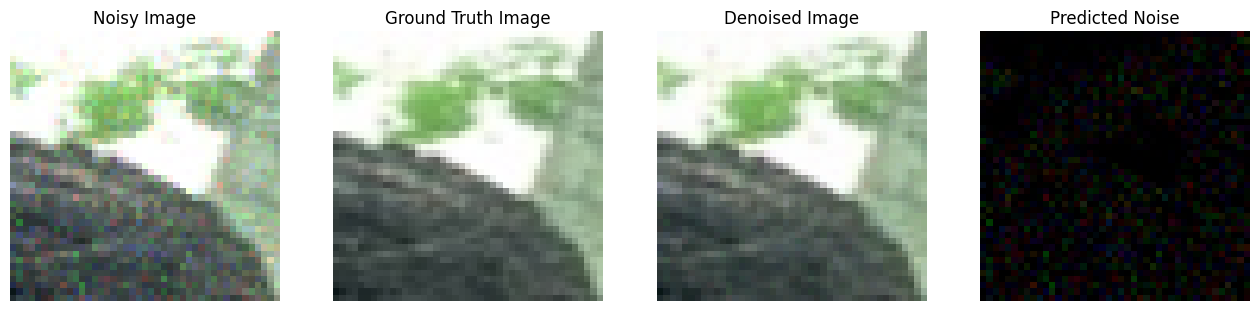

Epoch 19/50: 100%|██████████| 4225/4225 [00:55<00:00, 76.38it/s]


Epoch 19/50 | Train Loss: 0.0002 | Val Loss: 0.0003


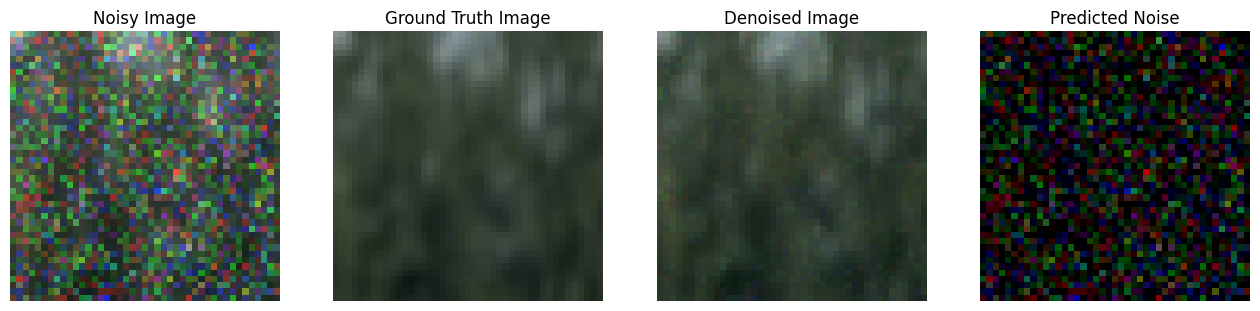

Epoch 20/50: 100%|██████████| 4225/4225 [00:55<00:00, 76.11it/s]


Epoch 20/50 | Train Loss: 0.0002 | Val Loss: 0.0002


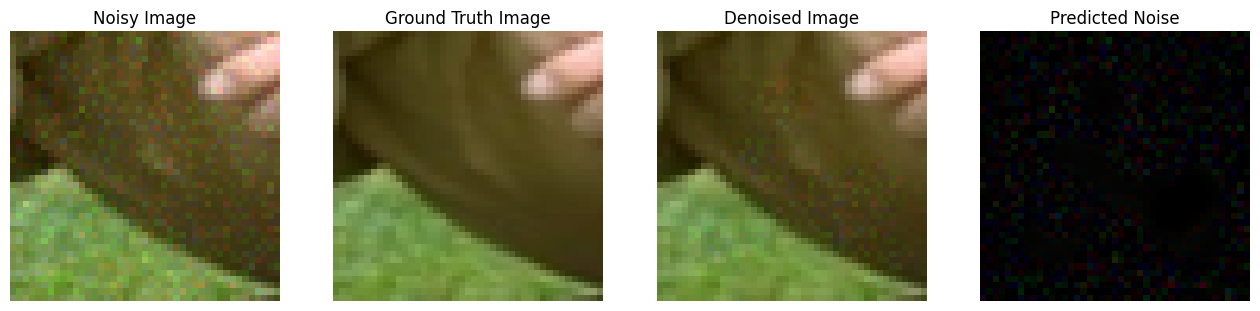

Epoch 21/50: 100%|██████████| 4225/4225 [00:55<00:00, 76.38it/s]


Epoch 21/50 | Train Loss: 0.0002 | Val Loss: 0.0004


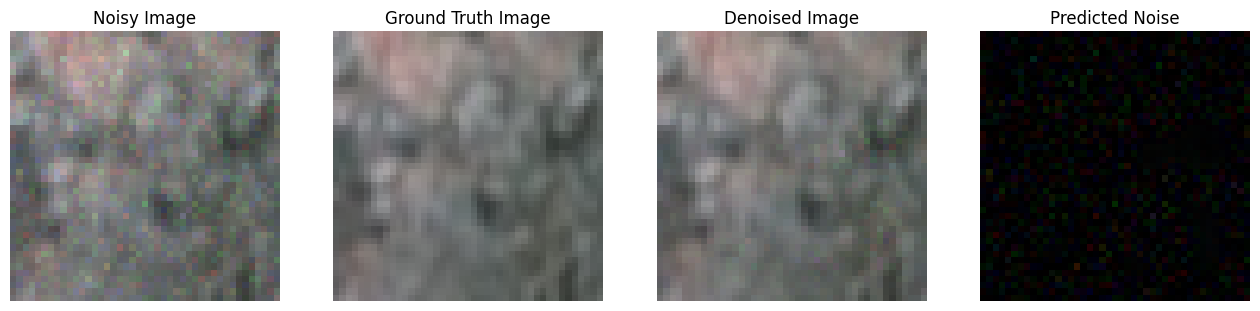

> Stopped training
> The lowest val loss was: 0.0002 in epoch 16


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DnCNN(in_channels=3).to(device)

early_stop = EarlyStopping(tolerance=5, min_delta=0.00001)

# Hyperparameters
num_epochs = 50
learning_rate = 1e-4
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f}", end=" ")
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    print(f"| Val Loss: {val_loss:.4f}")
    
    scheduler.step()
    early_stop(val_loss, model.state_dict(), optimizer.state_dict(), epoch)

    with torch.no_grad():
        x_val_sample, y_val_sample = next(iter(val_loader))
        x_val_sample, y_val_sample = x_val_sample.to(device), y_val_sample.to(device)
        pred_noise = model(x_val_sample)
        
        # Convert to CPU for visualization
        x_show = x_val_sample[0].cpu().permute(1, 2, 0).numpy()
        gt_noise_show = (y_val_sample[0]).cpu().permute(1, 2, 0).numpy()
        pred_noise_show = pred_noise[0].cpu().permute(1, 2, 0).numpy()
        
        denoised_show = x_show - pred_noise_show
        
        fig, ax = plt.subplots(1, 4, figsize=(16, 4))
        ax[0].imshow(x_show)
        ax[0].set_title('Noisy Image')
        ax[0].axis('off')

        ax[1].imshow(gt_noise_show, cmap='gray')
        ax[1].set_title('Ground Truth Image')
        ax[1].axis('off')
        
        ax[2].imshow(pred_noise_show, cmap='gray')
        ax[2].set_title('Denoised Image')
        ax[2].axis('off')

        ax[3].imshow(denoised_show)
        ax[3].set_title('Predicted Noise')
        ax[3].axis('off')
        plt.show()

    if early_stop.early_stop:
        print("> Stopped training")
        print(f"> The lowest val loss was: {early_stop.min_loss:.4f} in epoch {early_stop.epoch + 1}")
        break

In [11]:
model.load_state_dict(early_stop.model_dict)

<All keys matched successfully>

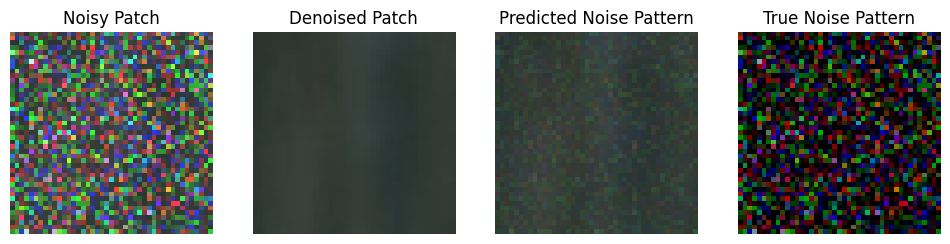

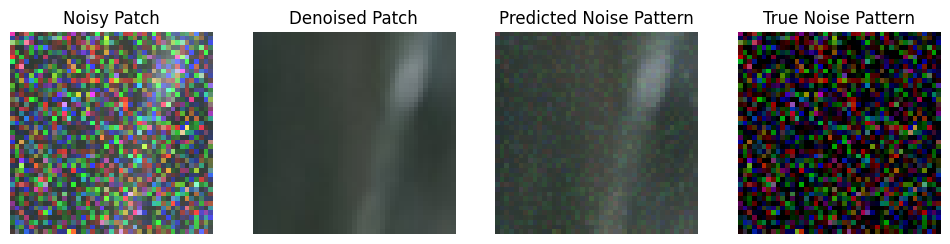

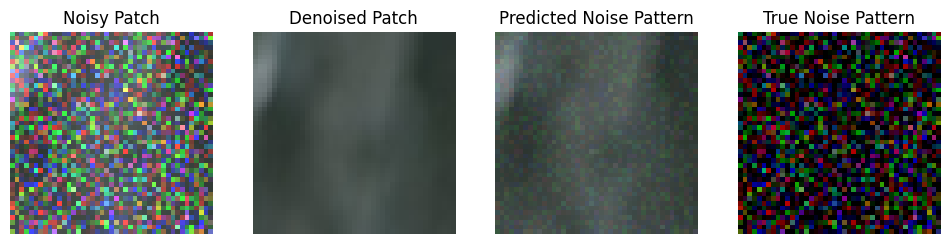

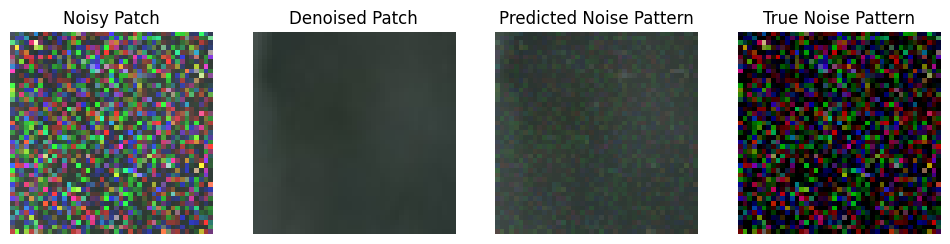

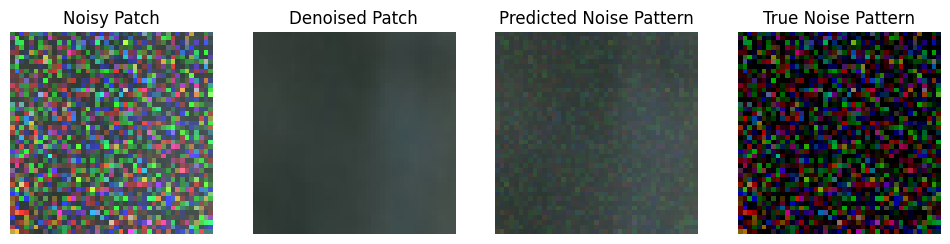

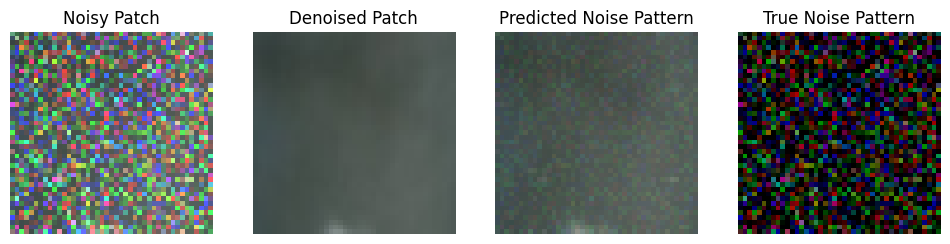

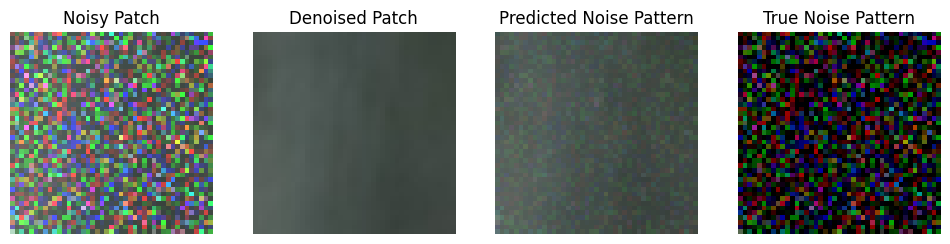

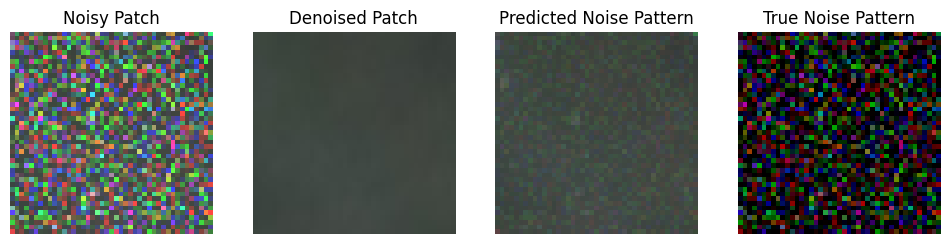

In [12]:
model.eval()
with torch.no_grad():
    # Fetch a batch of patches
    test_batch = next(iter(test_loader))
    noisy_patches, noise_patches = test_batch
    noisy_patches = noisy_patches.to(device)
    noise_patches = noise_patches.to(device)

    # Predict the noise pattern
    predicted_noise_patches = model(noisy_patches)
    predicted_noise_patches = torch.clamp(predicted_noise_patches, 0, 1).cpu()

    for idx in range(min(len(noisy_patches), 8)):  # Visualize up to 4 patches
        noisy_patch = noisy_patches[idx].cpu().permute(1, 2, 0).numpy()
        true_noise_patch = noise_patches[idx].cpu().permute(1, 2, 0).numpy()
        predicted_noise_patch = predicted_noise_patches[idx].permute(1, 2, 0).numpy()
        denoised_patch = noisy_patch - predicted_noise_patch

        # Display the noisy patch, true noise, predicted noise, and denoised patch
        fig, ax = plt.subplots(1, 4, figsize=(12, 4))
        
        ax[0].imshow(noisy_patch)
        ax[0].set_title('Noisy Patch')
        ax[0].axis('off')

        ax[1].imshow(true_noise_patch, cmap='gray')
        ax[1].set_title('Denoised Patch')
        ax[1].axis('off')

        ax[2].imshow(predicted_noise_patch)
        ax[2].set_title('Predicted Noise Pattern')
        ax[2].axis('off')

        ax[3].imshow(denoised_patch)
        ax[3].set_title('True Noise Pattern')
        ax[3].axis('off')

        plt.show()

In [13]:
def denoise_image(model, image_path, add_noise=True):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((Conf.image_hw, Conf.image_hw)),
        transforms.ToTensor()
    ])
    image_tensor = transform(image).unsqueeze(0)

    if add_noise:
        noise = torch.from_numpy(gaussian_noise(-20, image_tensor.shape)).float()
        noisy_image_tensor = torch.clamp(image_tensor + noise, 0, 1)
    else:
        noisy_image_tensor = image_tensor.clone()

    device = next(model.parameters()).device
    noisy_image_tensor = noisy_image_tensor.to(device)

    def extract_patches(img_tensor, patch_size, stride):
        C, H, W = img_tensor.shape[1], img_tensor.shape[2], img_tensor.shape[3]
        patches = []
        positions = []
        # Cover the entire height, including bottom edge
        for i in range(0, H, stride):
            for j in range(0, W, stride):
                # Compute the end indices
                end_i = min(i + patch_size, H)
                end_j = min(j + patch_size, W)
                
                patch = img_tensor[:, :, i:end_i, j:end_j]
                patches.append(patch)
                positions.append((i, j))
        return patches, positions


    patches, positions = extract_patches(noisy_image_tensor, Conf.patch_size, Conf.stride)

    denoised_patches = []
    model.eval()
    with torch.no_grad():
        for patch in patches:
            predicted_noise = model(patch)
            denoised_patch = predicted_noise
            denoised_patches.append(torch.clamp(denoised_patch, 0, 1))

    # Reconstruct the image from denoised patches
    C, H, W = noisy_image_tensor.shape[1], noisy_image_tensor.shape[2], noisy_image_tensor.shape[3]
    reconstructed = torch.zeros_like(noisy_image_tensor)
    patch_count = torch.zeros((1, 1, H, W), device=device)

    patch_size = Conf.patch_size
    for (i, j), dp in zip(positions, denoised_patches):
        reconstructed[:, :, i:i+patch_size, j:j+patch_size] += dp
        patch_count[:, :, i:i+patch_size, j:j+patch_size] += 1

    safe_patch_count = torch.where(patch_count == 0, torch.ones_like(patch_count), patch_count)
    denoised_image_tensor = reconstructed / safe_patch_count
    denoised_image_tensor = denoised_image_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()

    noisy_image_display = noisy_image_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(noisy_image_display)
    ax[0].set_title("Noisy Image")
    ax[0].axis('off')

    ax[1].imshow(denoised_image_tensor)
    ax[1].set_title("Denoised Image")
    ax[1].axis('off')
    
    ax[2].imshow(image_tensor.squeeze(0).permute(1, 2, 0))
    ax[2].set_title("Original Image")
    ax[2].axis('off')

    plt.show()

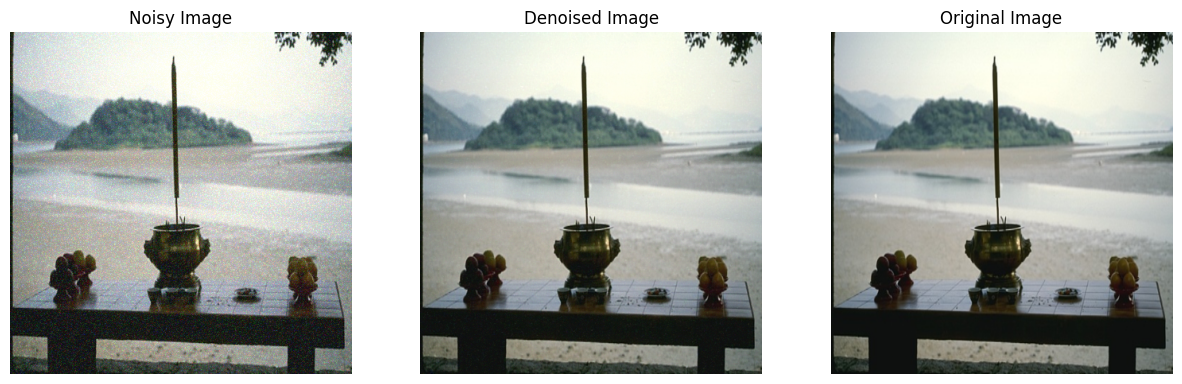

In [14]:
denoise_image(model, '/kaggle/input/berkeley-segmentation-dataset-500-bsds500/images/test/120003.jpg', add_noise=True)

In [15]:
torch.save(model.state_dict(), 'DnCNN.pth')